In [2]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
#pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

In [11]:
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio

# set up plotly defaults
pio.renderers.default = "plotly_mimetype+svg"
pio.templates["book"] = go.layout.Template(
    layout=dict(
        margin=dict(l=10, r=10, t=10, b=10),
        autosize=True,
        width=350,
        height=250,
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True),
        title=dict(x=0.5, xanchor="center"),
    )
)
pio.templates.default = "simple_white+book"

def margin(fig, **kwargs):
    """Set margins for a plotly figure"""
    return fig.update_layout(margin=kwargs)

# Exercises

## Exercise 1

- Write a SQL query on the `baby` relation, read the result into a `pandas`
  dataframe, and create a plot of how popular your name was over time. If you
  used that plot to make a guess at your age, what would you guess? Is that
  close to your actual age? Think of a potential reason.

### My solution

In [4]:
import sqlalchemy

In [7]:
db = sqlalchemy.create_engine('sqlite:///data/babynames.db')

In [13]:
#Plot of how popular "Shirley" is over time
query='''
SELECT *
FROM baby
WHERE Name = "Shirley"
  AND Sex = "F";
'''
Shirley = pd.read_sql(query,db)
Shirley

,Name,Sex,Count,Year
0,Shirley,F,135,2020
1,Shirley,F,147,2019
2,Shirley,F,152,2018
...,...,...,...,...
137,Shirley,F,18,1883
138,Shirley,F,9,1882
139,Shirley,F,8,1880


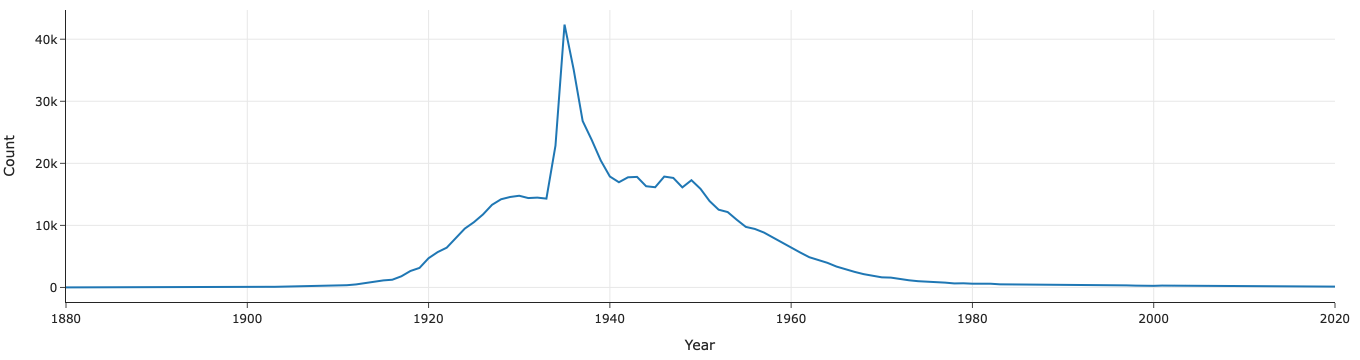

In [14]:
px.line(Shirley, x='Year', y='Count', width=350, height=250)

I would guess from this chart that anyone with my name is from the 1940s.

## Exercise 2

- When plotting male and female baby names over time, you might notice that
  after 1950 there are generally more male babies. Is this trend reflected in
  the U.S. census data? Go to the Census website
  (https://data.census.gov/cedsci/) and check.

### My solution

In [27]:
query = '''
SELECT Year, Sex, SUM(Count) AS Count
FROM baby
WHERE Year > 1949 
  AND Sex = "F"
GROUP BY Year, Sex
'''
girls = pd.read_sql(query,db)
girls


,Year,Sex,Count
0,1950,F,1632632
1,1951,F,1726895
2,1952,F,1787255
...,...,...,...
68,2018,F,1676884
69,2019,F,1651911
70,2020,F,1581301


In [26]:
query = '''
SELECT Year, Sex, SUM(Count) AS Count
FROM baby
WHERE Year > 1949 
  AND Sex = "M"
GROUP BY Year, Sex
'''
boys = pd.read_sql(query,db)
boys

,Year,Sex,Count
0,1950,M,1790453
1,1951,M,1882886
2,1952,M,1943768
...,...,...,...
68,2018,M,1810309
69,2019,M,1785527
70,2020,M,1706423


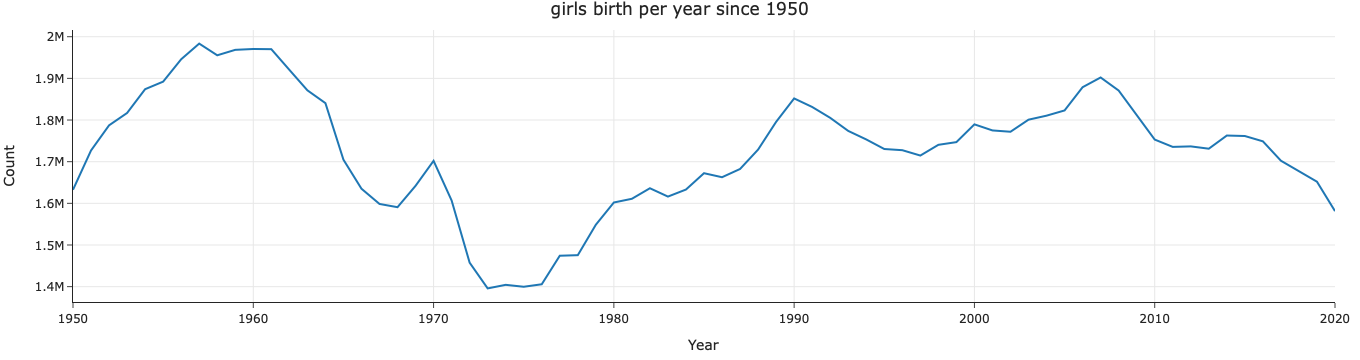

In [29]:
graph=px.line(girls, x='Year', y='Count',title="girls birth per year since 1950", width=350, height=250)
margin(graph, t=30)

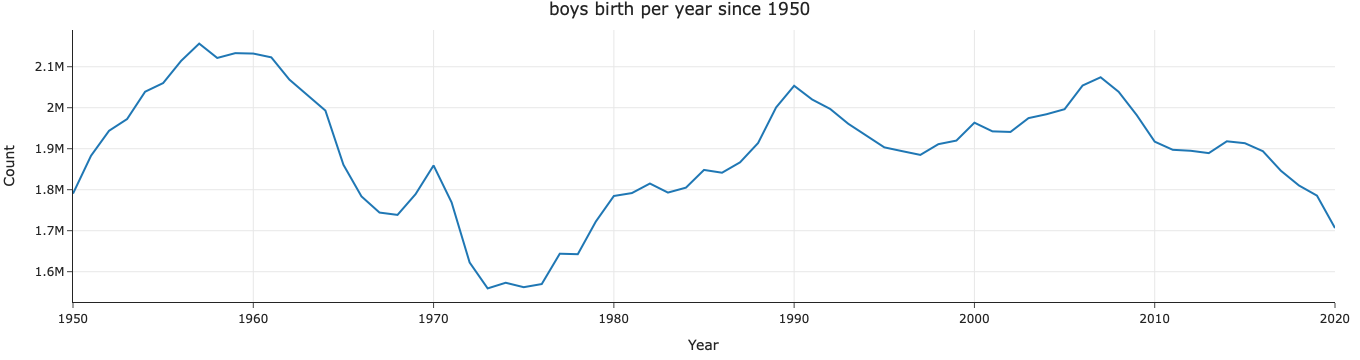

In [30]:
boys=px.line(boys, x='Year',y='Count',title="boys birth per year since 1950",width=350,height=250)
margin(boys,t=30)

The trends of boys and girls after the 1950s seems similar, except that there are around 0.1-0.2 million less birth of girls than boys throughtout the years.

## Exercise 3

- Let's say you want to find the most popular male and female baby name each
  year. You might write this query:

  ```sql
  SELECT Year, Sex, MAX(Count), MAX(Name)
  FROM baby
  GROUP BY Year, Sex
  ```

  But this code doesn't produce the right result. Why?

  Now, write code to produce the most popular male and female name each year,
  along with its count. *Hint:* The answer is a bit simpler than you might
  expect because of a special SQLite rule (search for "Bare columns in an
  aggregate queries"). 

### My Solution

In [32]:
#First, let's see what is wrong with the query:
query = '''
SELECT Year, Sex, MAX(Count), MAX(Name)
FROM baby
GROUP BY Year, Sex
'''
pd.read_sql(query,db)

,Year,Sex,MAX(Count),MAX(Name)
0,1880,F,2604,Zula
1,1880,M,9655,Zeke
2,1881,F,2698,Zula
...,...,...,...,...
279,2019,M,20555,Zyrus
280,2020,F,15581,Zyva
281,2020,M,19659,Zyrus


The names doesn't seem like the most popular ones. 

Bare columns in an aggregate queries. This is a really nice SQL tweak implemented in SQLite: If you run a query like “SELECT a, b, max(c) FROM tab1 GROUP BY a” SQLite will find the row with the highest value for c and use the columns of that row as the returned values for the other columns mentioned in the query.

What happened is that SQLite found the row with the highest value for c and used the columns of that row as the returned value for the MAX(Name).

In [36]:
query = '''
SELECT Year, Sex, Max(Count), Name
FROM baby
GROUP BY Year, Sex
'''
pd.read_sql(query,db)

,Year,Sex,Max(Count),Name
0,1880,F,2604,Anna
1,1880,M,9655,John
2,1881,F,2698,Anna
...,...,...,...,...
279,2019,M,20555,Liam
280,2020,F,15581,Emma
281,2020,M,19659,Liam


Instead, we could have just returned the Name that correlates with the Max(Count). Here we have a table with the correct most popular name of that year of both sexes.

## Exercise 4

- Come up with a realistic data example where a data scientist would prefer an
  inner join to a left join, and an example where a data scientist would
  prefer a left join to an inner join.

### My solution

I think an example of where a data scientist would prefer an inner join to a left join is when they want to find out what is overlapping for one column on two datasets. For example, if I want to make a table of kids who have two sets of data about them- then I would do an inner join of the two datasets of kids. 

An example of when I would prefer a left join to an inner join is when I want to enroll all the kids from dataset 1 but I want to collect their information from dataset 2, then I would want to left join dataset 1 with dataset 2 so all the kids on dataset 1 will remain on the table.

## Exercise 5

- In the section on Joins, the `nyt` table doesn't have any duplicate names.
  But a name could feasibly belong to multiple categories---for instance,
  `Elizabeth` is a name from the Bible and a name for royalty. Let's say we
  have a relation called `multi_cat` that can list a name multiple times---once
  for each category it belongs to:

### My solution

In [37]:
query = ''' 
SELECT *
FROM multi_cat
'''

pd.read_sql(query, db)

,nyt_name,category
0,Elizabeth,bible
1,Elizabeth,royal
2,Arjun,hindu
3,Arjun,mythological


What happens when we join `baby` with this table? In general, what happens when
there are *multiple rows* that match in both left and right tables?

In [38]:
query = '''
SELECT *
FROM multi_cat JOIN baby
  ON multi_cat.nyt_name = baby.Name
'''
pd.read_sql(query,db)

,nyt_name,category,Name,Sex,Count,Year
0,Elizabeth,bible,Elizabeth,F,1852,1881
1,Elizabeth,bible,Elizabeth,F,1939,1880
2,Elizabeth,bible,Elizabeth,F,2186,1882
...,...,...,...,...,...,...
649,Arjun,mythological,Arjun,M,577,2016
650,Arjun,mythological,Arjun,M,600,2018
651,Arjun,mythological,Arjun,M,650,2014


What happened is that multiple rows will appear that matches the names of both left and right tables. Here, Elizabeth that is in the category bible and royal from the multi_cat dataset got paired up with all the different years and sexs of the baby datasets, which created 651 rows. We can test if our hypothesis is correct by seeing the row number. The multi_cat table has 4 rows and the baby table has 2020-1881=139 rows for each name, and more if the name occurs as both sexes. S0 4 * 139 = 556 plus the opposite sexes that appears in names that caused the final row count of the joined table to be 651.

In [46]:
651-556

95

## Exercise 6

- In a *self-join*, we take a table and join it with itself. For example, the
  `friends` relation contains pairs of people who are friends with each other.

In [48]:
query = ''' 
SELECT *
FROM friends
'''

pd.read_sql(query, db)

,self,other
0,Jim,Scott
1,Scott,Philip
2,Philip,Tricia
3,Philip,Ailie


Why might a data scientist find the following self-join useful?

In [49]:
query = ''' 
SELECT *
FROM friends AS f1
  INNER JOIN friends AS f2
  ON f1.other = f2.self
'''

pd.read_sql(query, db)

,self,other,self,other
0,Jim,Scott,Scott,Philip
1,Scott,Philip,Philip,Ailie
2,Scott,Philip,Philip,Tricia


### My solution

It might be helpful to see who is the "wingman" or the middle person who connects two strangers together.

## Exercise 7

- The self-join query in the previous exercise uses the `AS` keyword to rename
  each relation. Why do we need to rename the relations in that query? In
  general, under what circumstances do we need to rename relations in the
  `FROM` clause? 

### My solution

We need to rename relation using the AS keyword when we don't like to use the column name as a function for example SUM(Count), or MAX(Count), so we use AS to rename it as Count.

We need to rename relations in the FROM clause when we use a method like SUBSTR(Name, 1, 1) and we want to call the column firsts so we use AS Firsts.

## Exercise 8

- Have names become longer on average over time? Write a SQL query, read the
  result into a `pandas` dataframe, then produce a plot to answer this
  question. 

### My solution

In [90]:
query = '''
SELECT *, Length(Name)
FROM baby
LIMIT 10
'''
pd.read_sql(query,db)

,Name,Sex,Count,Year,Length(Name)
0,Liam,M,19659,2020,4
1,Noah,M,18252,2020,4
2,Oliver,M,14147,2020,6
...,...,...,...,...,...
7,Lucas,M,11281,2020,5
8,Henry,M,10705,2020,5
9,Alexander,M,10151,2020,9


In [94]:
query = '''
WITH lengths AS (
  SELECT *, Length(Name) AS length
  FROM baby
)
SELECT Year, AVG(length) AS average
FROM lengths
GROUP BY Year;


'''
lengths=pd.read_sql(query,db)
lengths

,Year,average
0,1880,5.700850
1,1881,5.674599
2,1882,5.724835
...,...,...
138,2018,6.122976
139,2019,6.104031
140,2020,6.069524


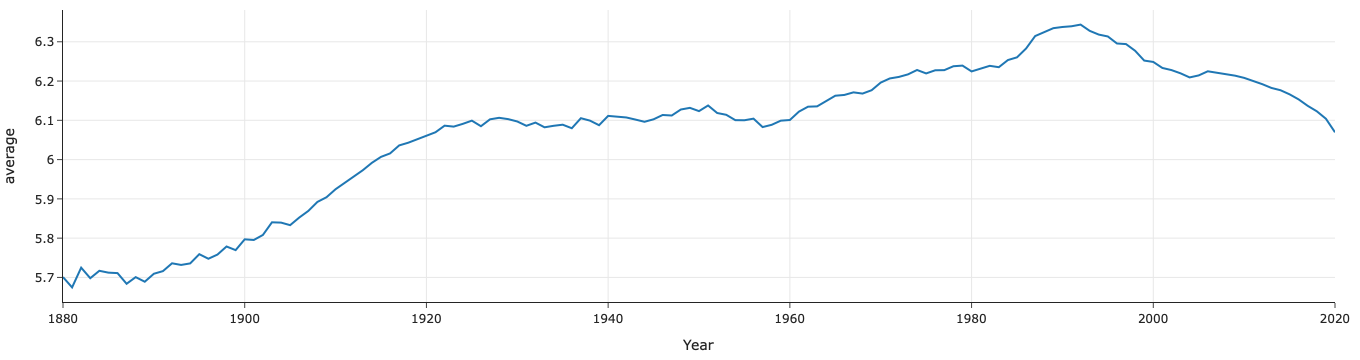

In [96]:
px.line(lengths,x='Year',y='average',width=350,height=250)

In [ ]:
Yes, names have become longer on average over time until the 

### Exercise 9

- What does the following SQL query compute? What does the `stat` column
  contain?

In [50]:
query = ''' 
WITH yearly_avgs AS (
  SELECT Name, AVG(Count) AS avg
  FROM baby
  GROUP BY Name
),
sq_diffs AS (
  SELECT b.Name, POWER(Count - avg, 2) AS sq_diff
  FROM baby AS b JOIN yearly_avgs AS y
    ON b.Name = y.Name
)
SELECT Name, POWER(AVG(sq_diff), 0.5) AS stat
FROM sq_diffs
GROUP BY Name
ORDER BY stat DESC
LIMIT 10
'''

pd.read_sql(query, db)

,Name,stat
0,Michael,28296.712872
1,Robert,26442.689927
2,James,26434.033277
...,...,...
7,Richard,15849.652195
8,Patricia,13428.249244
9,Matthew,13165.154404


### My solution 

The SQL query computes the standard deviation of yearly counts of each name. The stat column contains the value that is the standard deviation of yearly counts from most standard deviation to least.

## Exercise 10

- In this chapter we found that you could make reasonable guesses at a person's
  age just by knowing their name. For instance, the name "Luna" has sharply
  risen in popularity after 2000, so you could guess that a person named "Luna"
  was born around after 2000. Can you make reasonable guesses at a person's age
  just from the *first letter* of their name?
  
  Answer this question by writing a SQL query, reading the result into a
  `pandas` dataframe, then producing plots to see whether this is possible.
  Then, see which first letters provide the most information about a person's
  age. 

In [51]:
query = ''' 
WITH letters AS (
  SELECT *, SUBSTR(Name, 1, 1) AS Firsts
  FROM baby
)
SELECT Firsts, Year, SUM(Count) AS Count
FROM letters
GROUP BY Firsts, Year;
'''

letter_counts = pd.read_sql(query, db)
letter_counts

,Firsts,Year,Count
0,A,1880,16740
1,A,1881,16257
2,A,1882,18790
...,...,...,...
3638,Z,2018,55996
3639,Z,2019,55293
3640,Z,2020,54011


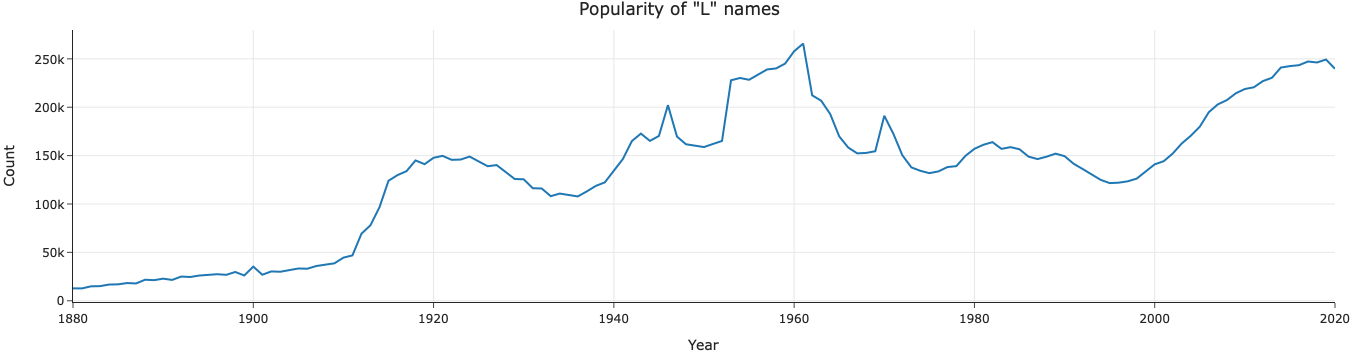

In [52]:
fig = px.line(letter_counts.loc[letter_counts['Firsts'] == 'L'],
              x='Year', y='Count', title='Popularity of "L" names',
              width=350, height=250)
margin(fig, t=30)

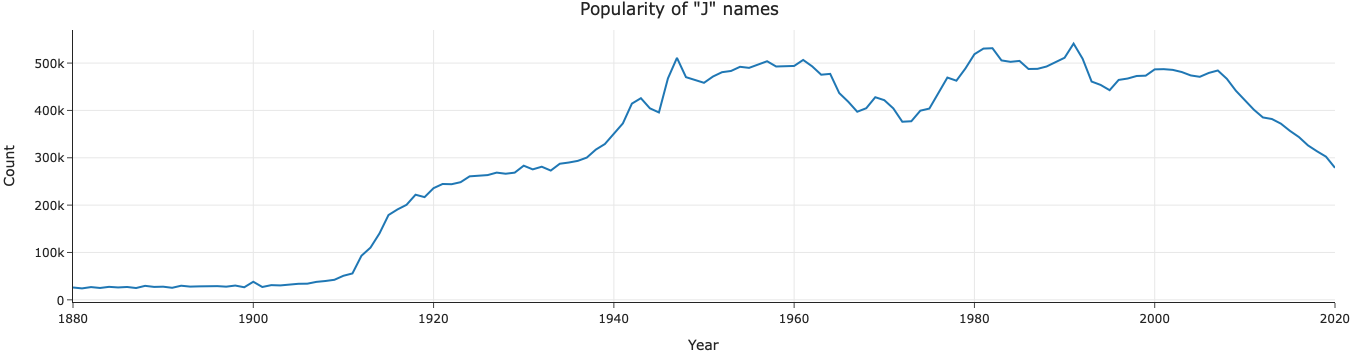

In [53]:
fig = px.line(letter_counts.loc[letter_counts['Firsts'] == 'J'],
              x='Year', y='Count', title='Popularity of "J" names',
              width=350, height=250)
margin(fig, t=30)

The plot shows that “L” names were popular in the 1960s, dipped in the decades after, but have indeed resurged in popularity after 2000.

The NYT article says that “J” names were popular in the 1970s and 80s. The plot agrees, and also shows that they have become less popular after 2000.

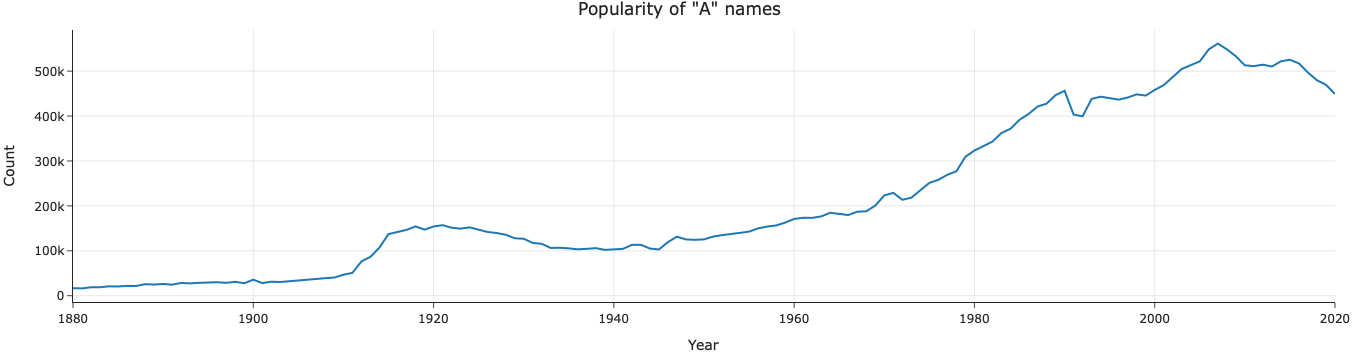

In [55]:
fig = px.line(letter_counts.loc[letter_counts['Firsts'] == 'A'],
              x='Year', y='Count', title='Popularity of "A" names',
              width=350, height=250)
margin(fig, t=30)

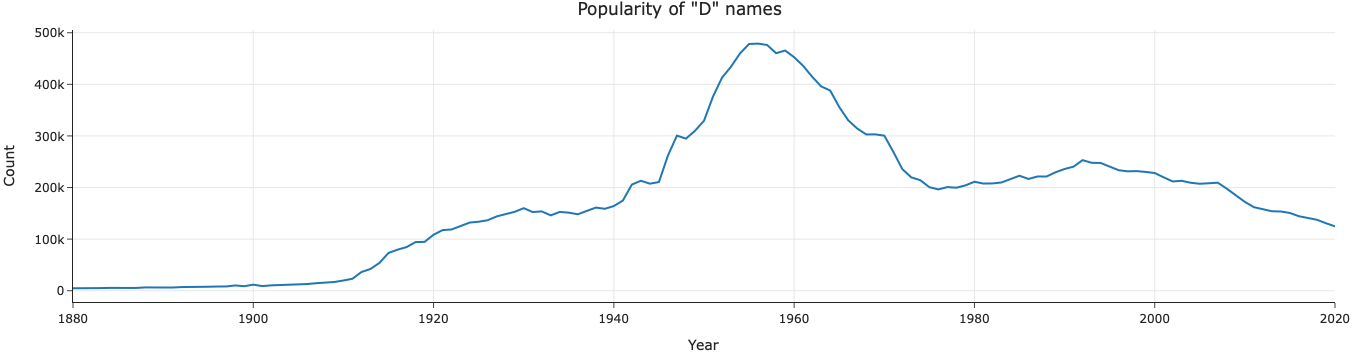

In [61]:
fig = px.line(letter_counts.loc[letter_counts['Firsts'] == 'D'],
              x='Year', y='Count', title='Popularity of "D" names',
              width=350, height=250)
margin(fig, t=30)

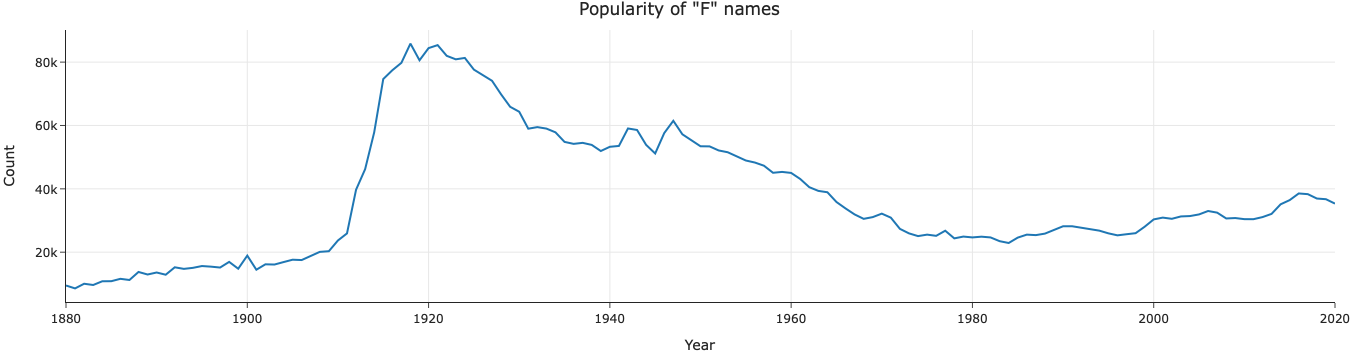

In [65]:
fig = px.line(letter_counts.loc[letter_counts['Firsts'] == 'F'],
              x='Year', y='Count', title='Popularity of "F" names',
              width=350, height=250)
margin(fig, t=30)

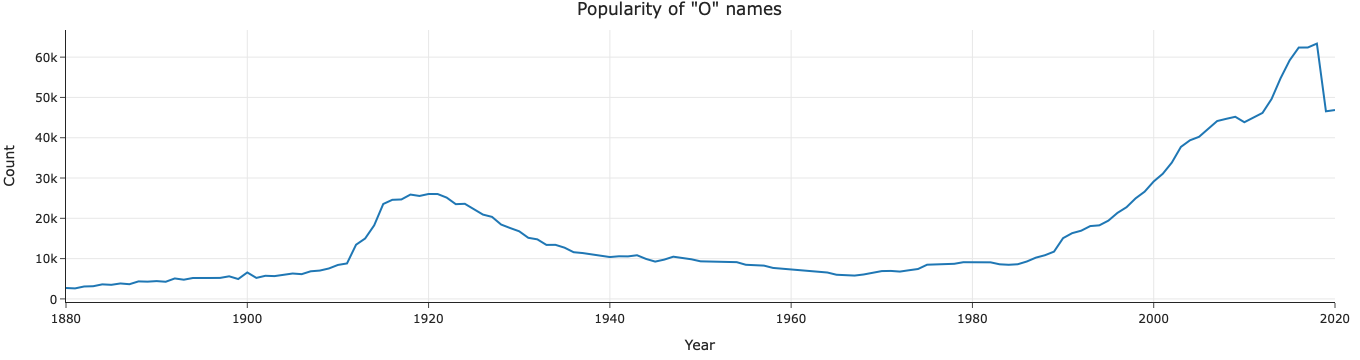

In [79]:
fig = px.line(letter_counts.loc[letter_counts['Firsts'] == 'O'],
              x='Year', y='Count', title='Popularity of "O" names',
              width=350, height=250)
margin(fig, t=30)

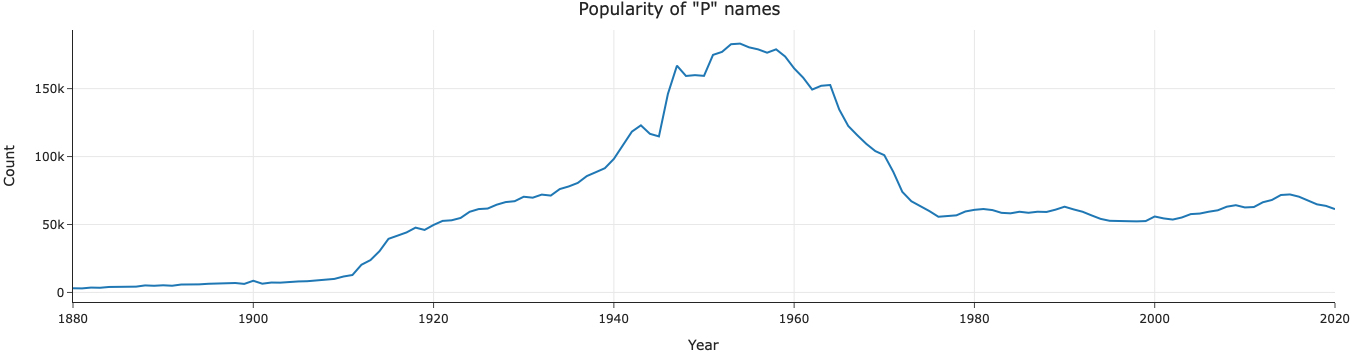

In [80]:
fig = px.line(letter_counts.loc[letter_counts['Firsts'] == 'P'],
              x='Year', y='Count', title='Popularity of "P" names',
              width=350, height=250)
margin(fig, t=30)

I would conclude it is sort of possible to guess a person's age from the first letter of their name, especially if the first letter starts with a "A" (2007), "D" (1955), "F"(1918), "O" (2018) or a "P" (1954).